In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import math
import matplotlib.pyplot as plt

In [10]:
def random_mini_batches(X, Y, mini_batch_size = None):
    '''Created minibatches for feeding into NN. First the dataset is randomized and then mini batches are
    made from the randomized set.
    
    Arguments:
    X -- array, shape(m, n)
    Y -- array, shape depends on how many classes. If it is binary then it is a vector.
    
    Return:
    mini_batches -- list of tuples which contain arrays.'''
    
    if mini_batch_size==None:
        return print('Need to specify a mini_batch_size.')
    else: 
        m = X.shape[0]
        
        mini_batches = []
         
        # shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :]#.reshape(m,1) if this was a label vector of shape(m, 1)
        
        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
        
            mini_batch_X = shuffled_X[k * mini_batch_size: (k + 1) * mini_batch_size, :]
            mini_batch_Y = shuffled_Y[k * mini_batch_size: (k + 1) * mini_batch_size, :]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X =shuffled_X[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch_Y =shuffled_Y[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
            
        return mini_batches

In [16]:
file_path = r"practice-data.pkl"
df = pd.read_pickle(file_path)

features = df.iloc[:, :-1]

# Turn labels to onehots
labels = np.array(df['crime'])

X_train, X_test, Y_train, Y_test = train_test_split(features, labels)
scalar = StandardScaler().fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

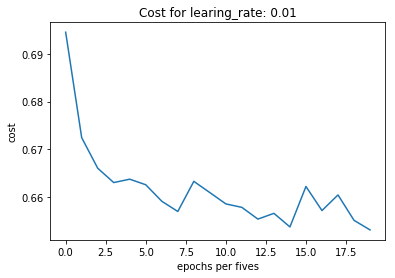

0.6208530805687204
0.5877551020408163
0.3684210526315789


In [18]:
tf.reset_default_graph()

learning_rate=0.01
sigmoid_thresh=0.5
X_trn = X_train
X_tst = X_test
Y_trn = Y_train.reshape(-1,1)  # In your MASTER script you had to do .values.reshape(-1,1)
Y_tst = Y_test
epochs=100
print_cost = True
    
# Create placeholders
X = tf.placeholder(tf.float32, shape=[None, 5], name='Input')
Y = tf.placeholder(tf.float32, shape=[None, 1], name='Output')

# Initialize weights
W1 = tf.get_variable(name='W1', shape=[5, 5], initializer=tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable(name='W2', shape=[5, 1], initializer=tf.contrib.layers.xavier_initializer())

# Initialize biases
b1 = tf.zeros(shape=[1, 5], name='b1')
b2 = tf.zeros(shape=[1, 1], name='b2')

# Hidden layer 1
Z1 = tf.add(tf.matmul(X, W1), b1, name='Z1')
A1 = tf.tanh(Z1, name='A1')

# Hidden layer 2
Z2 = tf.add(tf.matmul(A1, W2), b2, name='Z2')

pred_proba_A2 = tf.sigmoid(Z2, name='A2')
predictions = tf.to_float(tf.greater(pred_proba_A2, sigmoid_thresh, name='Predictions'))

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=Z2, name='Cost'))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='BackProp').minimize(cost)

init = tf.global_variables_initializer()

m_Xtrain = X_trn.shape[0]
mini_batch_size = 32
epochs=epochs
costs=[]

with tf.Session() as sess:
    sess.run(init)


    for epoch in range(epochs):

        num_batches = int(m_Xtrain/mini_batch_size)

        minibatches = random_mini_batches(X_trn, Y_trn, mini_batch_size = mini_batch_size)

        epoch_cost = 0

        for mini in minibatches:

            (minibatch_X, minibatch_Y) = mini

            _ , mini_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

            epoch_cost += mini_cost/num_batches

        if epoch % 5 == 0:
            costs.append(epoch_cost)

    if print_cost==True:
        plt.plot(costs)
        plt.title('Cost for learing_rate: {}'.format(learning_rate))
        plt.xlabel('epochs per fives')
        plt.ylabel('cost')
        plt.show()
    elif print_cost==False:
        None


    scores, preds = sess.run([pred_proba_A2, predictions], feed_dict={X: X_tst})

acc = accuracy_score(Y_tst, preds)
auc = roc_auc_score(Y_tst, scores)
f1 = f1_score(Y_tst, preds)

print(acc)
print(auc)
print(f1)

In [4]:
# Turn into a function
def nn_evaluation(X_trn, X_tst, Y_trn, Y_tst, learning_rate=0.01, sigmoid_thresh=0.5, epochs=100, print_cost=True):
    '''Fully connected 1-layer neural network with 5 hidden units in the hidden layer. The 
    The model is a for binary classification.
    
    Arguments:
    X_trn -- array, shape (m, 5)
    X_tst -- array, shape (m, 5)
    Y_trn -- int or float, binary labels of shape (m, 1)
    Y_tst -- int or float, binary labels of shape (m, 1)
    learning_rate -- float, controls learning rate for gradient descent (Adam)
    sigmoid_thresh -- float, threshold of sigmoid output activation.
    epochs -- int, number of iterations for training.
    print_cost -- Boolean, controls if ploting the costs is desired.
    
    Returns:
    preds -- array, predictions.
    auc -- float, Area Under the Curve.
    f1 -- float, harmonic balance between recall and precision.
    acc --  float, accuracy.
    '''
    tf.reset_default_graph()
    
    # Create placeholders
    X = tf.placeholder(tf.float32, shape=[None, 5], name='Input')
    Y = tf.placeholder(tf.float32, shape=[None, 1], name='Output')
    
    # Initialize weights
    W1 = tf.get_variable(name='W1', shape=[5, 5], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[5, 1], initializer=tf.contrib.layers.xavier_initializer())
    
    # Initialize biases
    b1 = tf.zeros(shape=[1, 5], name='b1')
    b2 = tf.zeros(shape=[1, 1], name='b2')
    
    # Hidden layer 1
    Z1 = tf.add(tf.matmul(X, W1), b1, name='Z1')
    A1 = tf.tanh(Z1, name='A1')

    # Hidden layer 2
    Z2 = tf.add(tf.matmul(A1, W2), b2, name='Z2')

    pred_proba_A2 = tf.sigmoid(Z2, name='A2')
    predictions = tf.to_float(tf.greater(pred_proba_A2, 0.5, name='Predictions'))

    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=Z2, name='Cost'))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='BackProp').minimize(cost)

    init = tf.global_variables_initializer()

    m_Xtrain = X_trn.shape[0]
    mini_batch_size = 32
    epochs=epochs
    costs=[]

    with tf.Session() as sess:
        sess.run(init)


        for epoch in range(epochs):

            num_batches = int(m_Xtrain/mini_batch_size)

            minibatches = random_mini_batches(X_trn, Y_trn, mini_batch_size = mini_batch_size)

            epoch_cost = 0

            for mini in minibatches:

                (minibatch_X, minibatch_Y) = mini

                _ , mini_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                epoch_cost += mini_cost/num_batches

            if epoch % 5 == 0:
                costs.append(epoch_cost)
        
        if print_cost==True:
            plt.plot(costs)
            plt.title('Cost for learing_rate: {}'.format(learning_rate))
            plt.xlabel('epochs per fives')
            plt.ylabel('cost')
            plt.show()
        elif print_cost==False:
            None


        scores, preds = sess.run([pred_proba_A2, predictions], feed_dict={X: X_tst})

    acc = accuracy_score(Y_tst, preds)
    auc = roc_auc_score(Y_tst, scores)
    f1 = f1_score(Y_tst, preds)

    return preds, auc, f1, acc

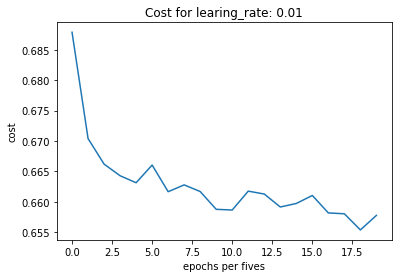

(array([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [5]:
nn_evaluation(X_train, X_test, Y_train, Y_test, learning_rate=0.01, sigmoid_thresh=0.5, epochs=100)